# `1.Import Libraries.`

<a href="https://colab.research.google.com/github/Manikanta-Munnangi/CROP---Plant-Disease-Identification-Using-App/blob/master/Cnn-Code/Crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libraries
import warnings
warnings.filterwarnings("ignore")

import os
import glob
import matplotlib.pyplot as plt
# Keras API
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D,Activation,AveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

# `2.Load Data into Train and Test Variables.`

In [2]:
# My data is in google drive.
train_dir ="D:\\Semester 6\\TARP\\tomato\\train"

test_dir="D:\\Semester 6\\TARP\\tomato\\val"

# `3.Function To count Images In Each Data Set.`

In [3]:
# function to get count of images
def get_files(directory):
  if not os.path.exists(directory):
    return 0
  count=0
  for current_path,dirs,files in os.walk(directory):
    for dr in dirs:
      count+= len(glob.glob(os.path.join(current_path,dr+"/*")))
  return count    

In [4]:
train_samples =get_files(train_dir)
num_classes=len(glob.glob(train_dir+"/*"))
test_samples=get_files(test_dir) # For testing i took only few samples from unseen data. we can evaluate using validation data which is part of train data.
print(num_classes,"Classes")
print(train_samples,"Train images")
print(test_samples,"Test images")

10 Classes
10000 Train images
1000 Test images


In [5]:
# Preprocessing data.
train_datagen=ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.2, # validation split 20%.
                                   horizontal_flip=True)

test_datagen=ImageDataGenerator(rescale=1./255)

In [6]:
# set height and width and color of input image.
img_width,img_height =256,256
input_shape=(img_width,img_height,1)
batch_size =32

train_generator =train_datagen.flow_from_directory(train_dir,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)
test_generator=test_datagen.flow_from_directory(test_dir,shuffle=True,
                                                   target_size=(img_width,img_height),
                                                   batch_size=batch_size)

Found 10000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [7]:
# The name of the 12 diseases.
train_generator.class_indices

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

# `4.CNN Parameter Building.`

In [8]:
#UNET MODEL
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
def multi_unet_model(n_classes=10, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
#     c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#     c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
#     c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#     c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#     c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
#     c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#     c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
#     c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    #outputs = Conv2D(1,(1, 1), activation='relu')(c9)
    
#     outputs =c9
#     model = Model(inputs=[inputs], outputs=[outputs])
    outputs = c9
    model = Model(inputs=[inputs],outputs =[outputs])
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [9]:
# CNN building.
model = Sequential()
model.add(multi_unet_model())
model.add(Conv2D(32, (5, 5),input_shape=input_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))   
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128,activation='relu'))          
model.add(Dense(num_classes,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 256, 256, 16)      1941088   
                                                                 
 conv2d_18 (Conv2D)          (None, 252, 252, 32)      12832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 84, 84, 32)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 82, 82, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 41, 41, 32)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 39, 39, 64)        1

In [10]:
model_layers = [ layer.name for layer in model.layers]
print('layer name : ',model_layers)

layer name :  ['model', 'conv2d_18', 'max_pooling2d_4', 'conv2d_19', 'max_pooling2d_5', 'conv2d_20', 'max_pooling2d_6', 'flatten', 'dense', 'dropout_1', 'dense_1', 'dense_2']


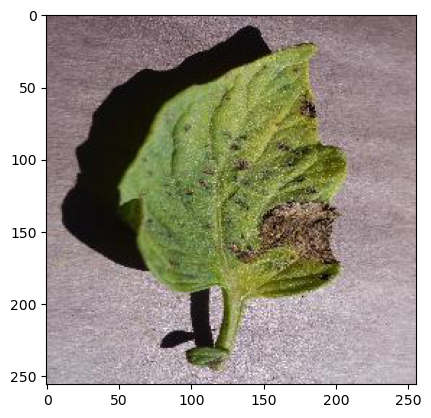

In [11]:
import keras.utils as image
import numpy as np
img1 = image.load_img('D:/semester 6/TARP/tomato/train/Tomato___Early_blight/fb956247-8c0b-486a-b491-4d49e77e598e___RS_Erly.B 7842.JPG')
plt.imshow(img1);

#preprocess image
img1 = image.load_img('D:/semester 6/TARP/tomato/train/Tomato___Early_blight/fb956247-8c0b-486a-b491-4d49e77e598e___RS_Erly.B 7842.JPG', target_size=(256, 256))
img = image.img_to_array(img1)
img = img/255
img = np.expand_dims(img, axis=0)

In [12]:
import warnings
warnings.filterwarnings("ignore")
from keras.models import Model

conv2d_1_output = Model(inputs=model.input, outputs=model.get_layer('conv2d_18').output)
max_pooling2d_1_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_4').output)
conv2d_2_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_19').output)
max_pooling2d_2_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_5').output)
conv2d_3_output = Model(inputs=model.input,outputs=model.get_layer('conv2d_20').output)
max_pooling2d_3_output = Model(inputs=model.input,outputs=model.get_layer('max_pooling2d_6').output)
flatten_1_output = Model(inputs=model.input,outputs=model.get_layer('flatten').output)



conv2d_1_features = conv2d_1_output.predict(img)
max_pooling2d_1_features = max_pooling2d_1_output.predict(img)
conv2d_2_features = conv2d_2_output.predict(img)
max_pooling2d_2_features = max_pooling2d_2_output.predict(img)
conv2d_3_features = conv2d_3_output.predict(img)
max_pooling2d_3_features = max_pooling2d_3_output.predict(img)
flatten_1_features = flatten_1_output.predict(img)

1/1 [==============================] - 1s 752ms/step


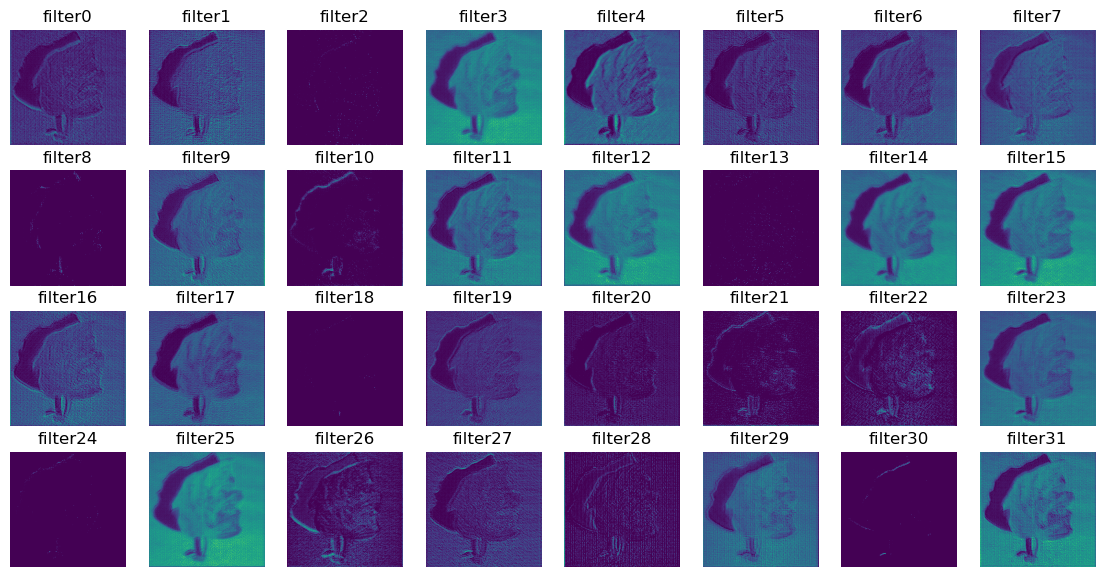

In [13]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_1_features[0, :, :, i], cmap='viridis') # Visualizing in color mode.
plt.show()

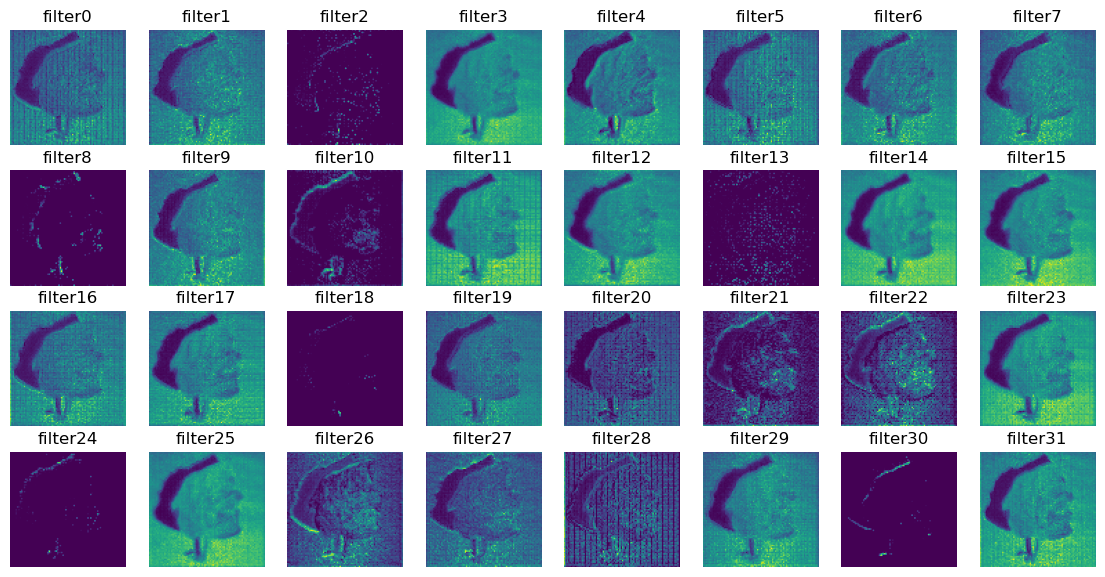

In [14]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_1_features[0, :, :, i], cmap='viridis')
plt.show()

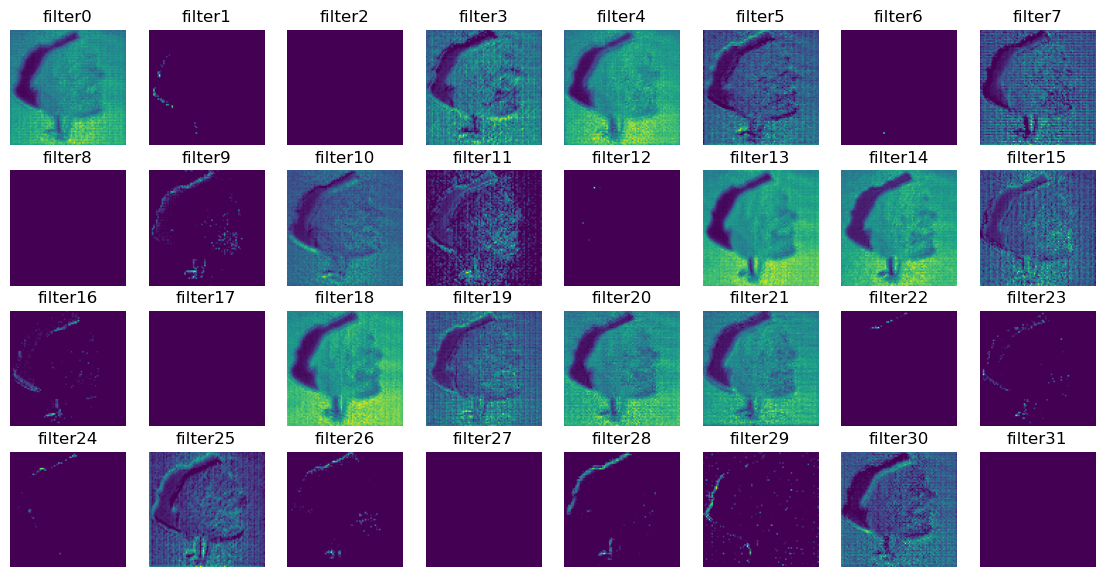

In [15]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_2_features[0, :, :, i], cmap='viridis')
plt.show()

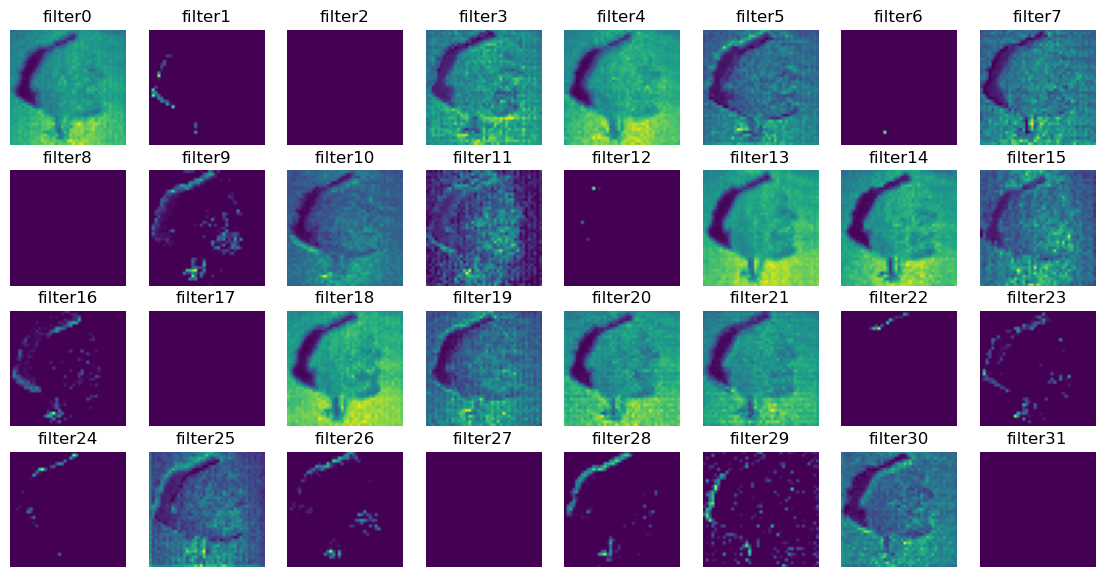

In [16]:
# we can also visualize in color mode.
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,7))
columns = 8
rows = 4
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_2_features[0, :, :, i], cmap='viridis') 
plt.show()

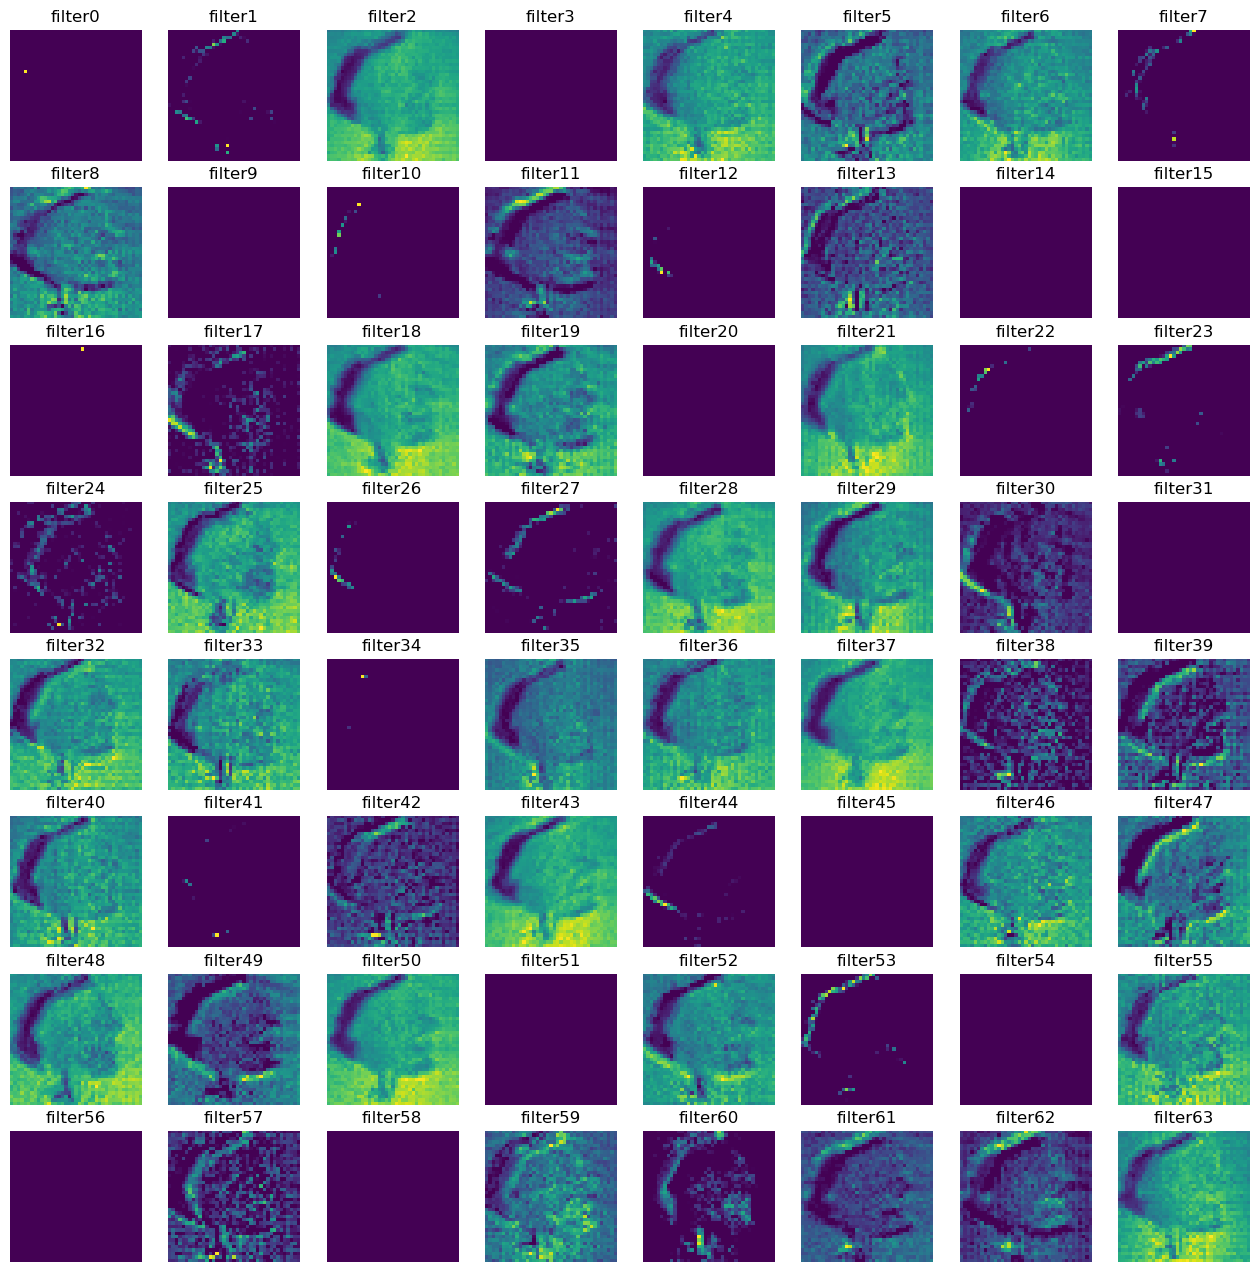

In [17]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(16,16))
columns =8 
rows = 8
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(conv2d_3_features[0, :, :, i], cmap='viridis')
plt.show()

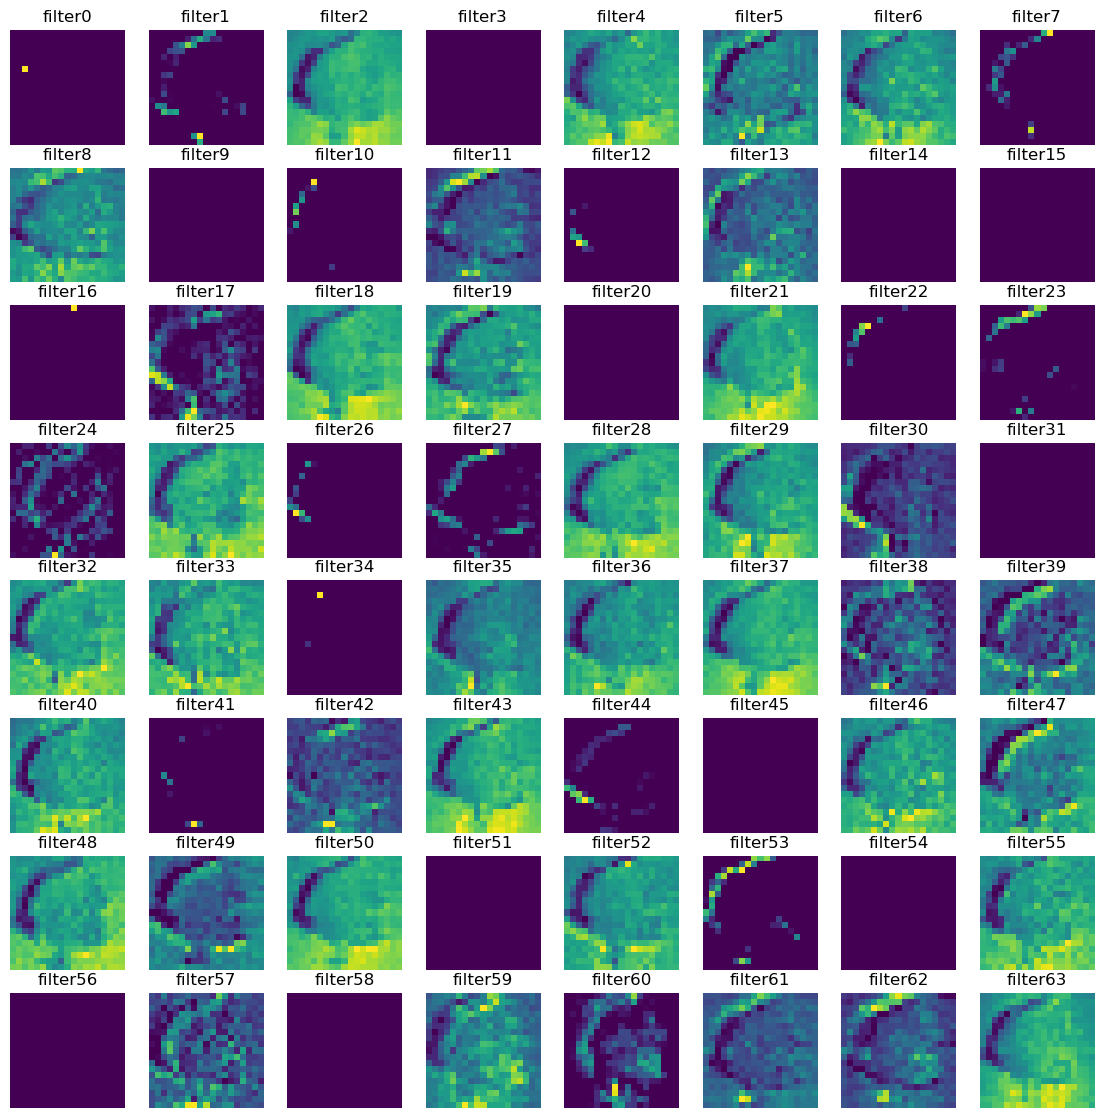

In [18]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(14,14))
columns = 8
rows = 8
for i in range(columns*rows):
    #img = mpimg.imread()
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title('filter'+str(i))
    plt.imshow(max_pooling2d_3_features[0, :, :, i],cmap='viridis')
plt.show()

# `6.Training The Model.`

In [19]:
# validation data.
validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size) 

Found 10000 images belonging to 10 classes.


In [20]:
#### Model building to get trained with parameters.
opt=keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
train=model.fit_generator(train_generator,
                          epochs=15,
                          steps_per_epoch=train_generator.samples // batch_size,
                          validation_data=validation_generator,
                          validation_steps= validation_generator.samples// batch_size,verbose=1)

Epoch 1/15
312/312 [==============================] - 4154s 13s/step - loss: 1.6308 - accuracy: 0.3913 - val_loss: 1.1986 - val_accuracy: 0.5611
Epoch 2/15
312/312 [==============================] - 4065s 13s/step - loss: 1.0338 - accuracy: 0.6207 - val_loss: 1.1176 - val_accuracy: 0.5926
Epoch 3/15
312/312 [==============================] - 4087s 13s/step - loss: 0.7918 - accuracy: 0.7126 - val_loss: 0.8271 - val_accuracy: 0.7077
Epoch 4/15
312/312 [==============================] - 4101s 13s/step - loss: 0.6256 - accuracy: 0.7753 - val_loss: 0.5893 - val_accuracy: 0.7877
Epoch 5/15
312/312 [==============================] - 4338s 14s/step - loss: 0.5385 - accuracy: 0.8105 - val_loss: 0.3720 - val_accuracy: 0.8713
Epoch 6/15
312/312 [==============================] - 5736s 18s/step - loss: 0.4312 - accuracy: 0.8476 - val_loss: 0.4327 - val_accuracy: 0.8496
Epoch 7/15
312/312 [==============================] - 3925s 13s/step - loss: 0.3901 - accuracy: 0.8597 - val_loss: 0.2302 - val_ac

# `7.Plot For Accuracy And Losses.`

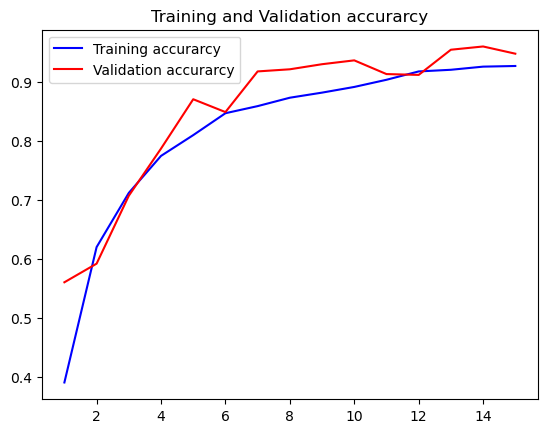

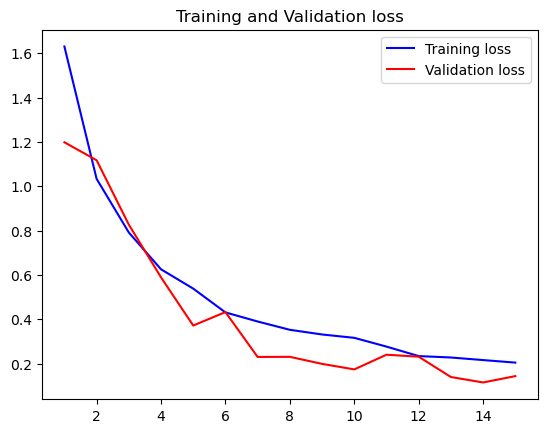

In [21]:
acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

# `8. Evaluate model using unseen data.`


In [22]:
score,accuracy =model.evaluate(test_generator,verbose=1)
print("Test score is {}".format(score))
print("Test accuracy is {}".format(accuracy))

32/32 [==============================] - 86s 3s/step - loss: 0.3084 - accuracy: 0.9020
Test score is 0.3083682358264923
Test accuracy is 0.9020000100135803


In [23]:
from sklearn.metrics import classification_report

# Generate predictions for the test dataset
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = predictions.argmax(axis=1)

# Get the true labels from the test generator
true_classes = test_generator.classes

# Calculate precision, recall, and F1-score
report = classification_report(true_classes, predicted_classes)

print(report)

32/32 [==============================] - 92s 3s/step
              precision    recall  f1-score   support

           0       0.04      0.04      0.04       100
           1       0.14      0.14      0.14       100
           2       0.07      0.08      0.08       100
           3       0.12      0.12      0.12       100
           4       0.07      0.07      0.07       100
           5       0.05      0.06      0.06       100
           6       0.11      0.08      0.09       100
           7       0.14      0.14      0.14       100
           8       0.10      0.10      0.10       100
           9       0.11      0.11      0.11       100

    accuracy                           0.09      1000
   macro avg       0.10      0.09      0.09      1000
weighted avg       0.10      0.09      0.09      1000



32/32 [==============================] - 85s 3s/step
[[14  7 12 14 13 10  3 12  7  8]
 [10 13 10  8  7  8 11  7  9 17]
 [10 10 10  6 11 14  5 13 12  9]
 [12 13  9  7  8 11  8 14 10  8]
 [10 12 10 16  8  9 11  7  7 10]
 [ 8  8 13  9 12 12  4 14 11  9]
 [13  7  9  8 13 14  9  8 11  8]
 [12  9  7 12  7 10  8 11 11 13]
 [10  9 16  9 11 13 11  3  6 12]
 [10  9 12  9  8 11  4 12 16  9]]


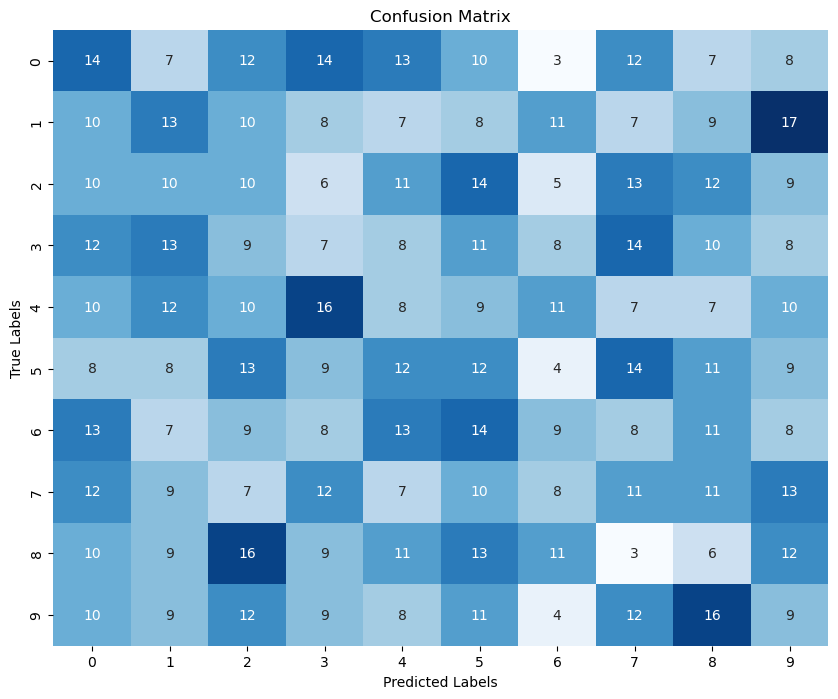

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions for the test dataset
predictions = model.predict(test_generator)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the test generator
true_classes = test_generator.classes

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)
# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
import time

def calculate_latency(model, input_sample):
    start_time = time.time()

    # Perform inference on the input sample
    model.predict(input_sample)

    end_time = time.time()
    latency = end_time - start_time

    return latency

latency = calculate_latency(model, test_generator)
print(f"Latency: {latency} seconds")


32/32 [==============================] - 86s 3s/step
Latency: 86.44941926002502 seconds


# `9.Saving Model.` 

In [26]:
# Save entire model with optimizer, architecture, weights and training configuration.
from keras.models import load_model
model.save('./crop.h5')

In [27]:
# Save model weights.
from keras.models import load_model
model.save_weights('./crop_weights.h5')

In [28]:
# Get classes of model trained on
classes = train_generator.class_indices 
classes


{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

# `10.Load Model.`

In [29]:
# Loading model and predict.
from keras.models import load_model
model=load_model('crop.h5')

Classes = ["Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___Late_blight","Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot","Tomato___Tomato_mosaic_virus","Tomato___healthy"]


# `11.Time For Predictions.`

1/1 [==============================] - 1s 825ms/step
Tomato___Early_blight


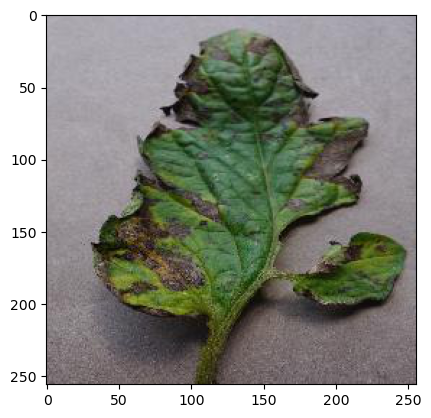

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import keras.utils as image
#from tensorflow.keras.utils import load_img, img_to_array 

# Pre-Processing test data same as train data.
img_width=256
img_height=256
#model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

#from keras.preprocessing import image

def prepare(img_path):
    img = image.load_img(img_path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = x/255
    return np.expand_dims(x, axis=0)

from __future__ import annotations
    
#result = model.predict_classes([prepare('C:/Users/ruchi/Downloads/tomato leaf/val/Tomato___Bacterial_spot/1e0582c9-3b55-4aaf-b63b-f223c13eac86___GCREC_Bact.Sp 5571.JPG')])
result = (model.predict([prepare('D:/Semester 6/TARP/tomato/val/Tomato___Early_blight/Tomato___Early_blight_original_0f7a2408-9c26-4ff9-bee5-2bfcd91a11f7___RS_Erly.B 9440.JPG_ad8df3fb-424e-4896-b34a-e8cdcb01a41e.JPG')]) > 0.5).astype("int32")
disease=image.load_img('D:/Semester 6/TARP/tomato/val/Tomato___Early_blight/Tomato___Early_blight_original_0f7a2408-9c26-4ff9-bee5-2bfcd91a11f7___RS_Erly.B 9440.JPG_ad8df3fb-424e-4896-b34a-e8cdcb01a41e.JPG')
plt.imshow(disease)
print (Classes[result.argmax()])

1/1 [==============================] - 0s 205ms/step
Tomato___Septoria_leaf_spot


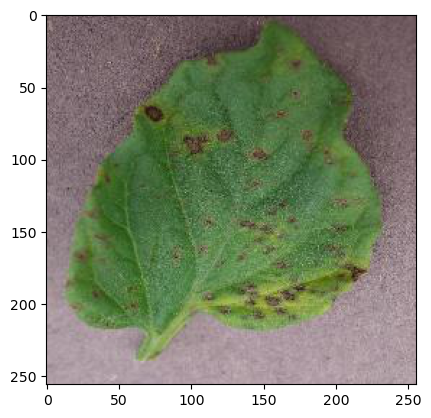

In [31]:
result2 = (model.predict([prepare('D:/Semester 6/TARP/tomato/val/Tomato___Septoria_leaf_spot/02d2c484-8bdb-4ef2-8d07-0bdb3ac330cc___Matt.S_CG 0975.JPG')]) > 0.5).astype("int32")
disease2=image.load_img('D:/Semester 6/TARP/tomato/val/Tomato___Septoria_leaf_spot/02d2c484-8bdb-4ef2-8d07-0bdb3ac330cc___Matt.S_CG 0975.JPG')
plt.imshow(disease2)
print (Classes[result2.argmax()])